In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from keras import layers
from keras.models import Model

In [2]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
data = data.fillna(method="ffill")
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [6]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [7]:
words=list(data['Word'].unique())
words.append("ENDPAD")
num_words = len(words)
tags=list(data['Tag'].unique())
num_tags = len(tags)
print("Unique tags are:", tags)

Unique tags are: ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func=lambda s:[(w,p,t)for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]  
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences
len(sentences)
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
X1 = [[word2idx[w[0]] for w in s] for s in sentences]

In [10]:
max_len = 100
X = sequence.pad_sequences(maxlen=max_len,sequences=X1, padding="post",value=num_words-1)
y1 = [[tag2idx[w[2]] for w in s] for s in sentences]
Y = sequence.pad_sequences(maxlen=max_len,sequences=y1,padding="post",value=tag2idx["O"])
Xtrain,Xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.2,random_state=1)

In [11]:
input_word = layers.Input(shape=(max_len,))

embedding_layer = layers.Embedding(input_dim=num_words,output_dim=50,input_length=max_len)(input_word)

dropout = layers.SpatialDropout1D(0.1)(embedding_layer)

bid_lstm = layers.Bidirectional(layers.LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(dropout)

output = layers.TimeDistributed(layers.Dense(num_tags,activation="softmax"))(bid_lstm)

model = Model(input_word, output)  

model.summary()

C:\Users\SEC\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 50)             │       1,758,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 200)            │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 100, 17)             │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,883,167 (7.18 MB)

 Trainable params: 1,883,167 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [13]:
model.fit(x=Xtrain, y=ytrain, validation_data=(Xtest,ytest),batch_size=50,epochs=3,)

Epoch 1/3
768/768 ━━━━━━━━━━━━━━━━━━━━ 208s 249ms/step - accuracy: 0.9614 - loss: 0.2185 - val_accuracy: 0.9891 - val_loss: 0.0398
Epoch 2/3
768/768 ━━━━━━━━━━━━━━━━━━━━ 194s 253ms/step - accuracy: 0.9909 - loss: 0.0321 - val_accuracy: 0.9922 - val_loss: 0.0264
Epoch 3/3
768/768 ━━━━━━━━━━━━━━━━━━━━ 191s 248ms/step - accuracy: 0.9937 - loss: 0.0210 - val_accuracy: 0.9927 - val_loss: 0.0242


In [ ]:
metrics = pd.DataFrame(model.history.history)

Text(0.5, 1.0, 'Training Accuracy vs. Validation Accuracy')

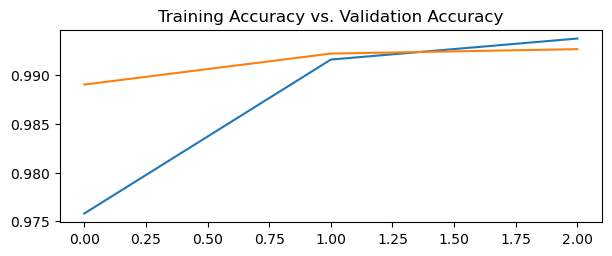

In [36]:
plt.figure(figsize=(7,2.5))
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs. Validation Accuracy')

Text(0.5, 1.0, 'Training Loss vs. Validation Loss')

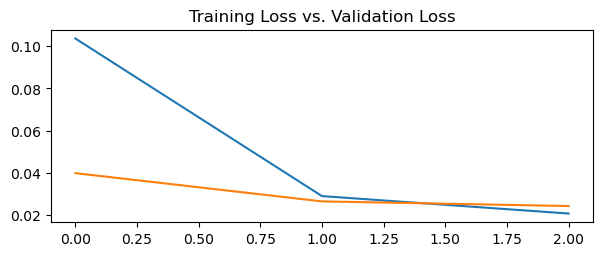

In [38]:
plt.figure(figsize=(7,2.5))
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training Loss vs. Validation Loss')

In [19]:
i = 21
p = model.predict(np.array([Xtest[i]]))
p = np.argmax(p, axis=-1)
ytrue = ytest[i]
print("ROHIT JAIN D - 212222230120")
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(Xtest[i], ytrue, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
ROHIT JAIN D - 212222230120
Word           True 	 Pred

------------------------------
On             O	O
Tuesday        B-tim	B-tim
,              O	O
Lebanon        B-geo	B-geo
's             O	O
ambassador     O	O
to             O	O
the            O	O
United         B-geo	B-geo
States         I-geo	I-geo
,              O	O
Imad           B-geo	B-geo
Moustapha      I-geo	I-org
,              O	O
said           O	O
the            O	O
troop          O	O
pullout        O	O
would          O	O
be             O	O
complete       O	O
long           O	O
before         O	O
May            B-tim	B-tim
,              O	O
when           O	O
Lebanon        B-geo	B-geo
holds          O	O
its            O	O
parliamentary  O	O
elections      O	O
.              O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         O	O
Bermel         